# BPL_YEAST_AIR_Fedbatch - demo

Author: Jan Peter Axelsson

This notebook demonstrate yeast fedbatch cultivation. We look at impact of changes in the glucose feeding. We also take a look at tuning of the DO-control system. Both liquid- and gasphase are included in the model. The culture growth and metabolism are formulated in relation to to the respiratory capacity [1] and the model is exapanded to describe also the gas phase as well as  the culture heat production [2]. The model was derived mainly from continuous culture data but proved to capture dynamic aspects well of ethanol production and consumption [3]. 

Interaction with the compiled model as FMU is mainly through the simplified commands: par(), init(), newplot(), simu() etc. The last simulation is always available in the workspace and called 'sim_res'. The command describe() brings mainly up description infomration from the actual Modelica code from the FMU but is complemented with information given in the dedicated Python setup-file.

The idea is to demonstrate how simulations and varyiing conditions can provide some process insight that can support the experimetnal work. I hope that at the end of this session you are ready to formulate your own questions you want to address with simulations - and you can just go on in this notebook! Just press the field "+Code" in the upper left part of notebook interface and you get a new "cell" where you write your own code. You can copy and paste from cells above using ctrol-c and ctrl-p as usual and edit the cell. When your are ready to execute the cell just press the "play button" to the left in the cell or press shift-enter as in "ordinary" Jupyter notebooks.

After a session you may want to save your own notebook. That you can do on your Google Drive account and I refer to Colab instructions for how to do this. It is easy. 

Enjoy!

In [1]:
run -i BPL_YEAST_AIR_Fedbatch_DOcontrol_fmpy_explore.py

Windows - run FMU pre-compiled JModelica 2.14

Model for bioreactor has been setup. Key commands:
 - par()       - change of parameters and initial values
 - init()      - change initial values only
 - simu()      - simulate and plot
 - newplot()   - make a new plot
 - show()      - show plot from previous simulation
 - disp()      - display parameters and initial values from the last simulation
 - describe()  - describe culture, broth, parameters, variables with values/units

Note that both disp() and describe() takes values from the last simulation
and the command process_diagram() brings up the main configuration

Brief information about a command by help(), eg help(simu)
Key system information is listed with the command system_info()


In [2]:
plt.rcParams['figure.figsize'] = [36/2.54, 30/2.54]

## About the process model

We can get information about the process, liquid- and gas-phase by the command describe(). This command can also be used to bring up information about a specific variable or parameter. However, you should use describe() after a simulation to get the valued used during the simulation.

In [3]:
describe('culture'); print(); #describe('liquidphase'); print(); describe('gasphase')

Saccharomyces cerevisae - default parameters for strain H1022



The model of the process has parameters both for culture, gas_liquid_transfer, as well as feeding procedure. The paramters that are available for changes you find by the command disp() and you get a long list and you change by them by command par(). The model has even more parameters in the background but not made available for interaction. 

No processDiagram.png file in the FMU, but try the file on disk.


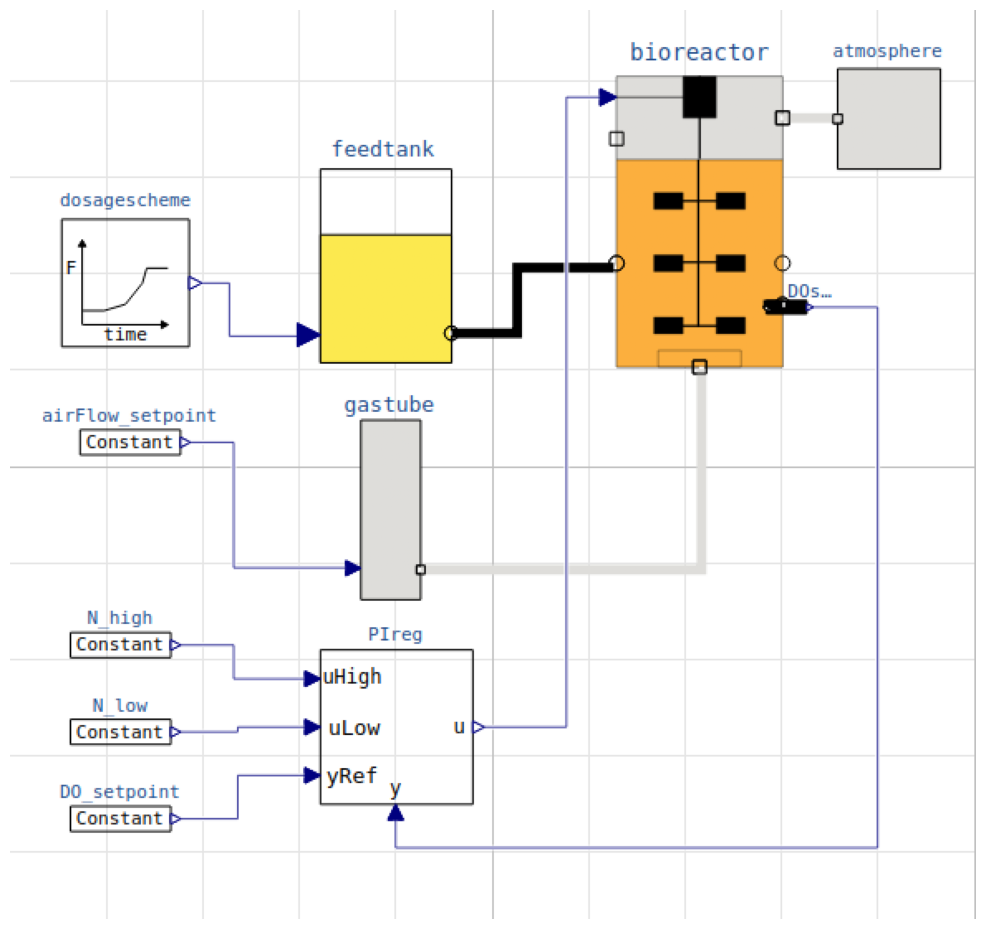

In [4]:
process_diagram()

## First simulations - adjusting start of substrate feeding

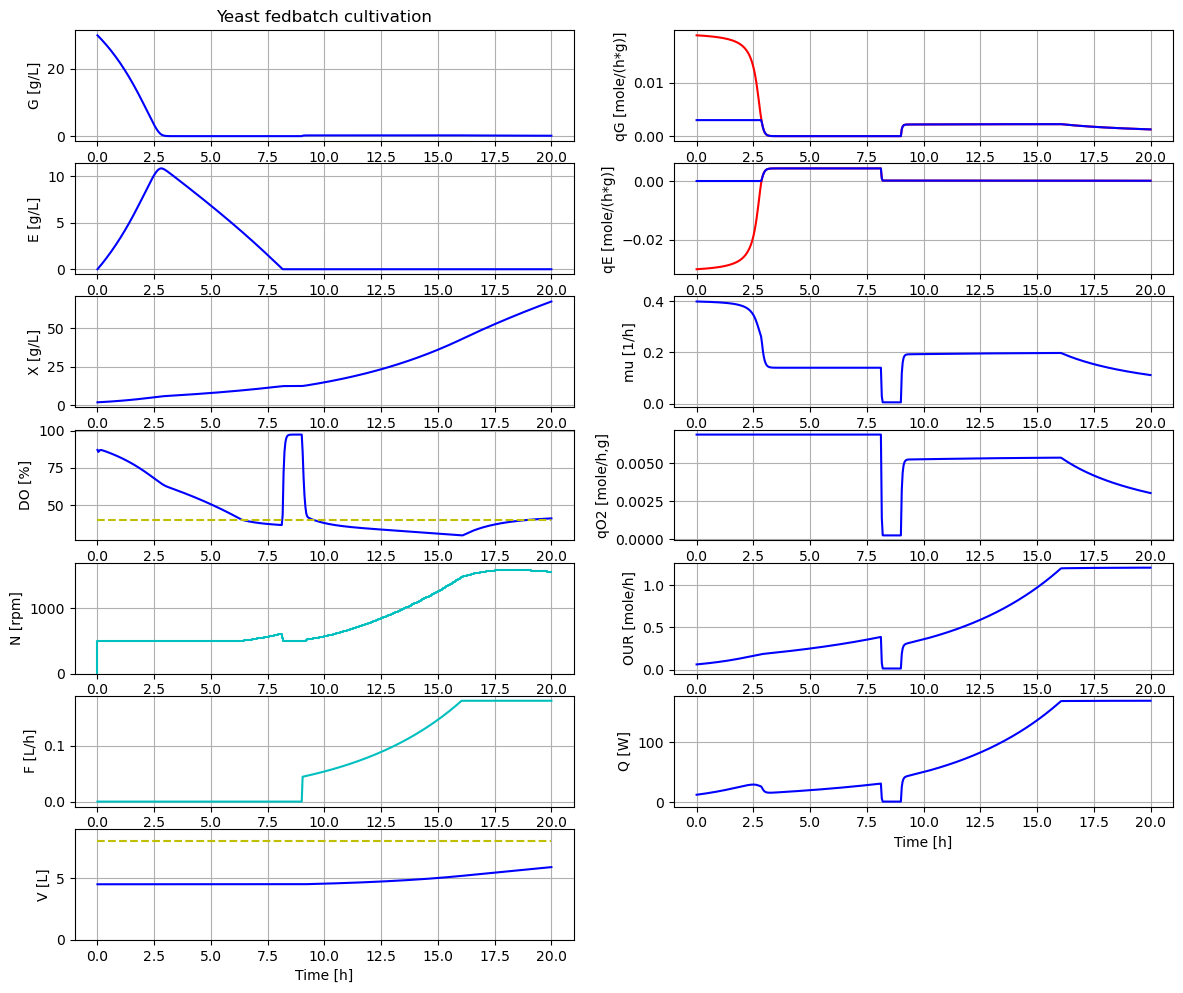

In [5]:
# Culture parameters and others at default values
par(qO2lim=0.0069) 

# Process initial conditions
init(V_start=4.5, VG_start=4.5*30, VX_start=4.5*2, VE_start=4.5*0) 

# Feed profile
par(t_startExp=9, F_startExp=0.044, mu_feed=0.20, F_max=0.18)  

# DO-control parameters
#par(samplePeriod=1/60, K=10, Ti=0.5, I_0=500)   
par(K=10, Ti=0.5, I_start=0)   

# Simulate and plot
newplot(title='Yeast fedbatch cultivation', plotType='Overview')
simu(20)

Now we can get value of broth volume as well as the headspace and values are the last ones in the simulation

In [6]:
describe('bioreactor.V')

Reactor broth volume : 5.892 [ L ]


In [7]:
describe('bioreactor.V_gasphase')

Volume of the gas phase : 2.108 [ L ]


In [8]:
# Take a look at the parameters available to adjust the dosage scheme
disp('dosage', decimals=4)

F_start : 0.0
mu_feed : 0.2
t_startExp : 2.0
F_startExp : 0.12
F_max : 3.0


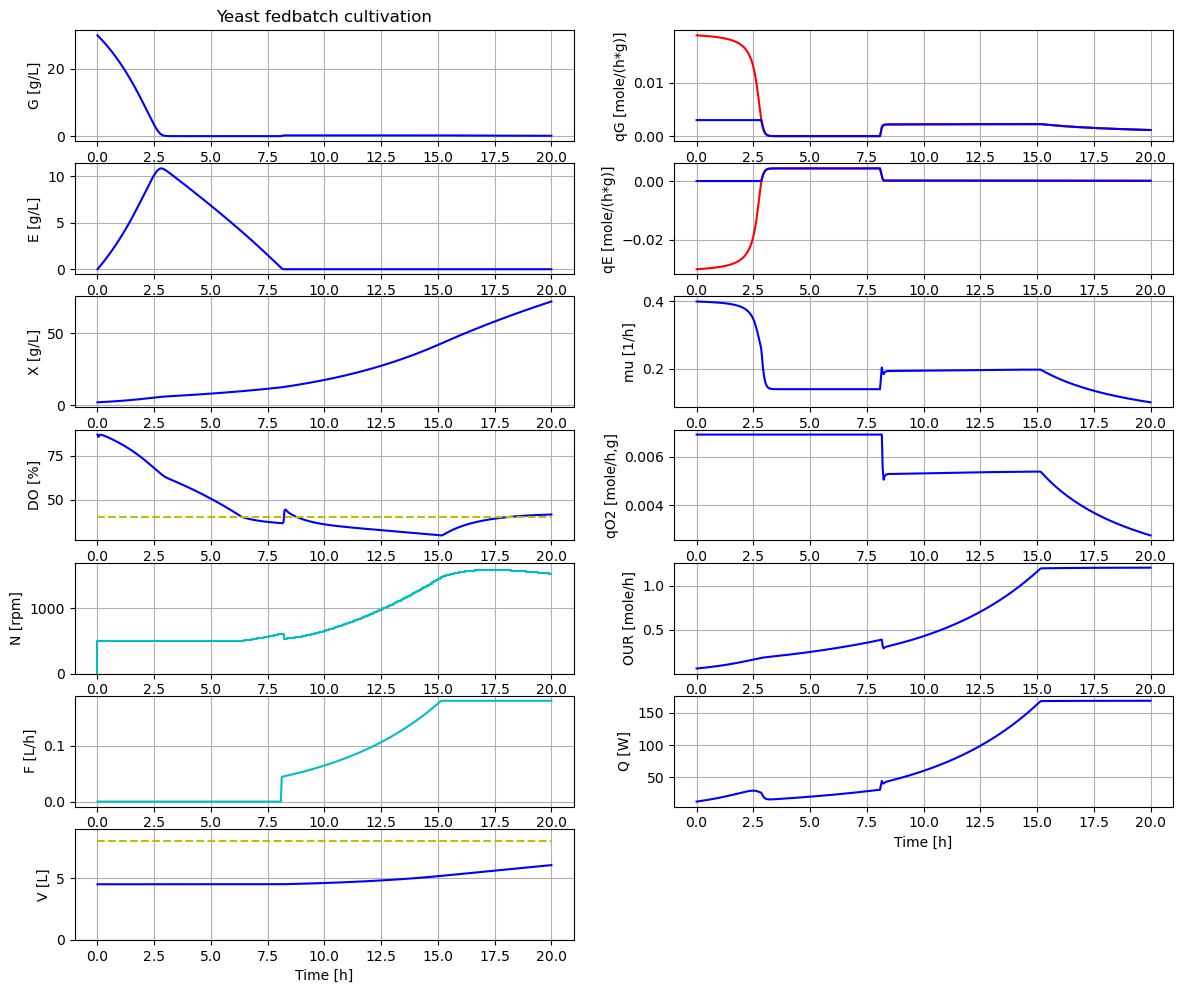

In [9]:
# Let us start the feeding just after the batch phase has ended and keep other parameters the same
par(t_startExp=8.1)

# Simulate and plot
newplot(title='Yeast fedbatch cultivation', plotType='Overview')
simu(20)

The increase of DO to about 50 % at end of batch phase should be possible to detect easily. This simulation is more realistic and we use these settings from now on.

## DO-control  - tuning of PI-regulator parameters

Let us focus on the DO-control system and choose a more limited plotType. We study the impact of PI control parameters and see if we can decrease the control error without looing stability.

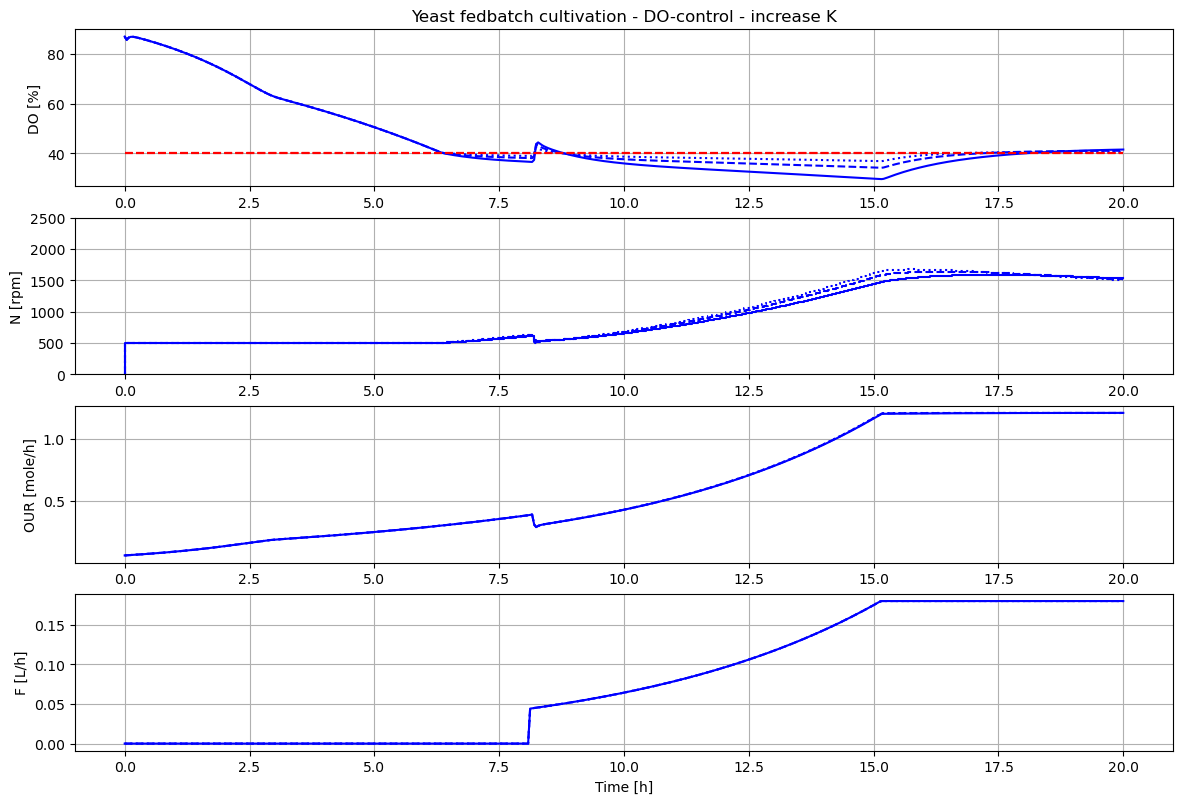

In [10]:
# Let us take a closer look at the DO-control system and try to make control error smaller by increaseing K
newplot(title='Yeast fedbatch cultivation - DO-control - increase K', plotType='Focus DO-control')
for value in [10, 20, 40]: par(K=value); simu(20)

# Reset K to the original value
par(K=10)

We see that by a higher control gain K the DO-control error get smaller and the stability of the control system is maintained.

In [11]:
diagrams

["ax1.plot(sim_res['time'],sim_res['DOsensor.out'],color='b',linestyle=linetype)",
 "ax1.plot(sim_res['time'],sim_res['DO_setpoint.out'],color='r',linestyle='--')",
 "ax2.step(sim_res['time'],sim_res['bioreactor.N'],color='b',linestyle=linetype)",
 'ax2.set_ylim([0,2500])',
 "ax3.plot(sim_res['time'],sim_res['bioreactor.m[1]']*sim_res['bioreactor.culture.qO2'],color='b',linestyle=linetype)",
 "ax4.plot(sim_res['time'],sim_res['bioreactor.inlet[1].F'],color='b',linestyle=linetype)"]

**Exercise** I leave for you to study the impact variation of the Ti-parameter. Just make a new cell below. Then copy and paste the cell above and change parameter to Ti.

## Sensitivity to changes in feed-profile

Now, let us focus on investigating impact of changes in the feed-profile. The goal is to increase the produced cell mass without accumulation of by-product ethanol. Simulation can bring some insight into how behaviour of the differen variables change when by-product is formed. This insight can help to interpret experimental results.

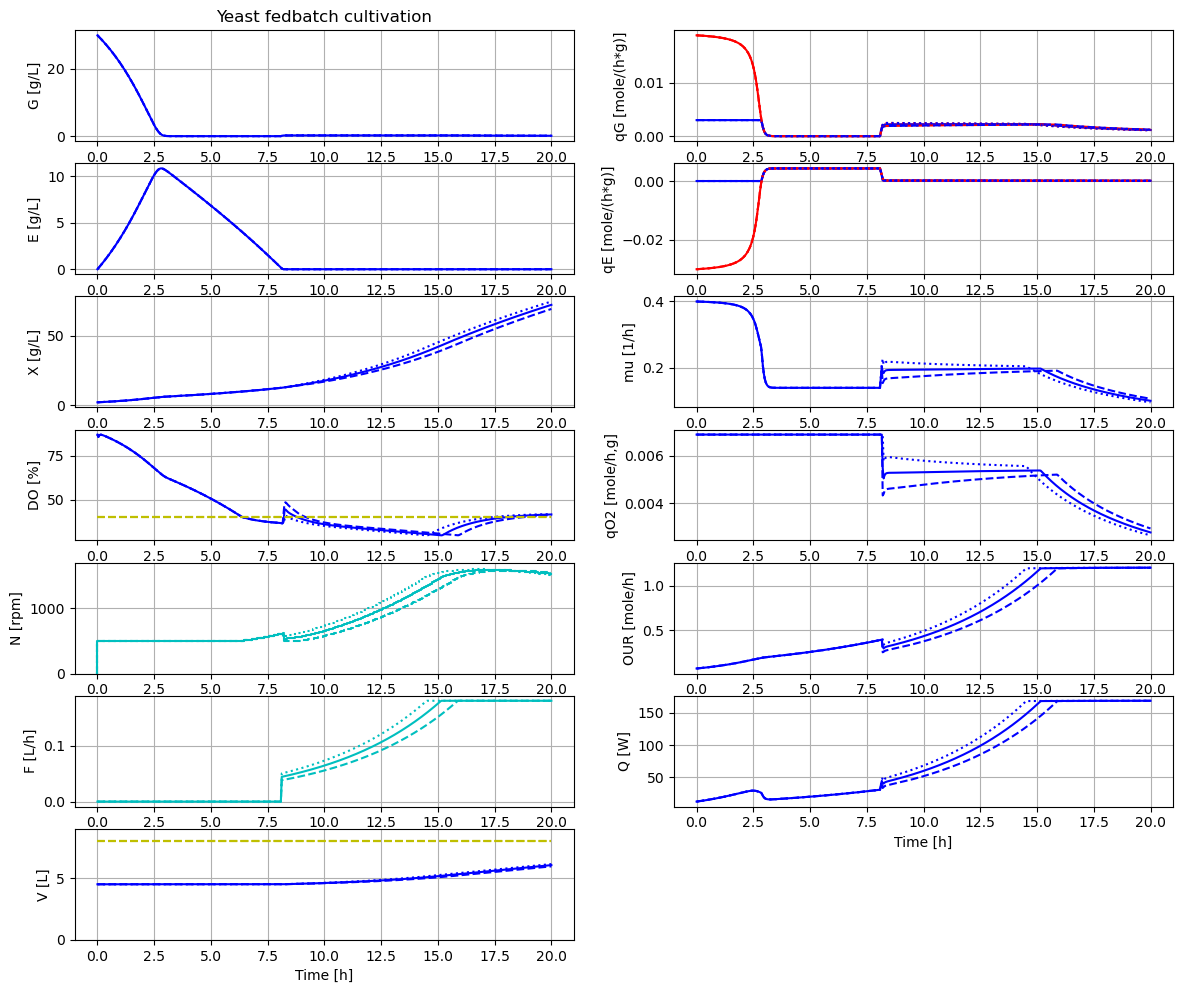

In [12]:
# Let us check the sensitivity to changes in the feed profile design
newplot(title='Yeast fedbatch cultivation', plotType='Overview')
for value in [0.044, 0.038, 0.050]: par(F_startExp=value); simu(20)

The variation in F_start has an impact and we see that the actual growth rate during fedbatch phase do converge to the set growth rate of the feed, but i takes more than 5 hours.

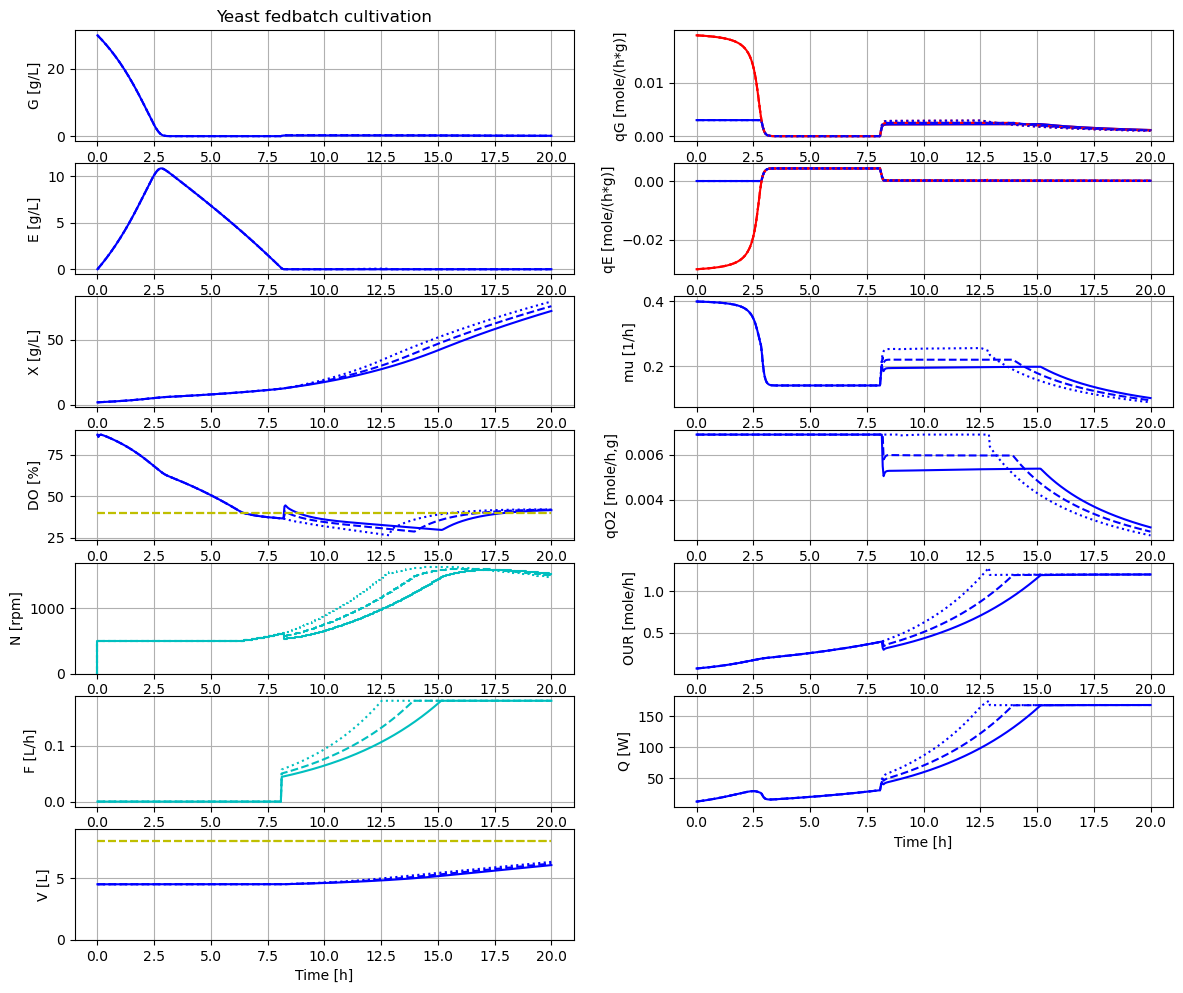

In [13]:
# Let us investigate a feedprofile that is closer to the maximal capacity
newplot(title='Yeast fedbatch cultivation', plotType='Overview')
par(F_startExp=0.044, mu_feed=0.20); simu(20)
par(F_startExp=0.050, mu_feed=0.22); simu(20)
par(F_startExp=0.057, mu_feed=0.26); simu(20)

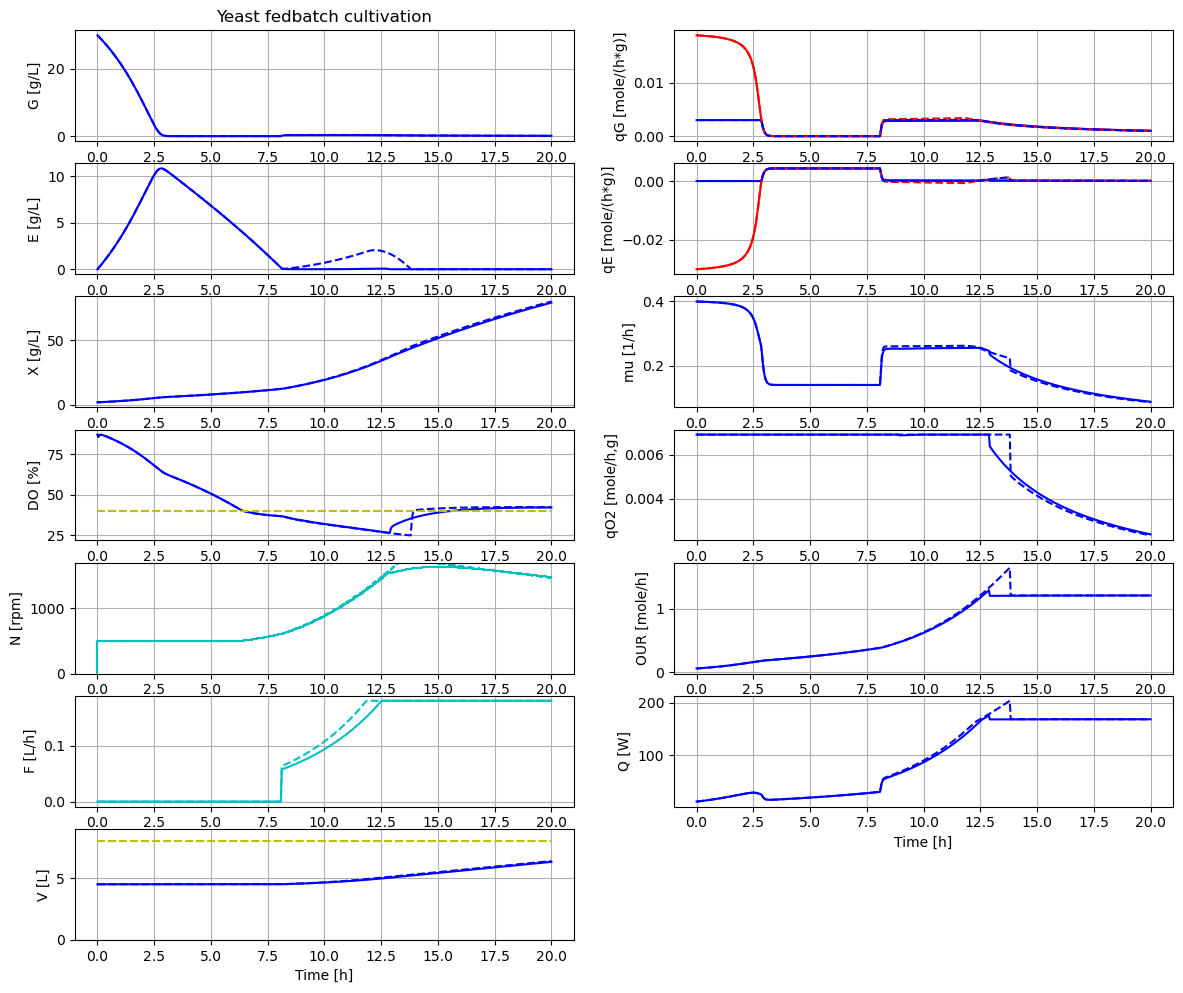

In [14]:
# And let us see what happens if the feedprofile exceed the culture capacity
newplot(title='Yeast fedbatch cultivation', plotType='Overview')
par(F_startExp=0.057, mu_feed=0.26); simu(20)
par(F_startExp=0.063, mu_feed=0.28); simu(20)
par(F_startExp=0.044, mu_feed=0.20)

Note that with the feedprofile that exceed culture respiratory capacity, ethanol is accumulated during time 8-12.5 hours. When the feedprofile then is constant from time 12.5 hours and on, then the accumulated ethanol is consumed over about an hour. This leads to a higher oxygen demand and heat production during this time. The specific cell growth rate is also slightly higher during this period.

**Exercise** You can investiate the impact of changing the maximal feedrate F_max. Make sure that the DO level do not get too low.

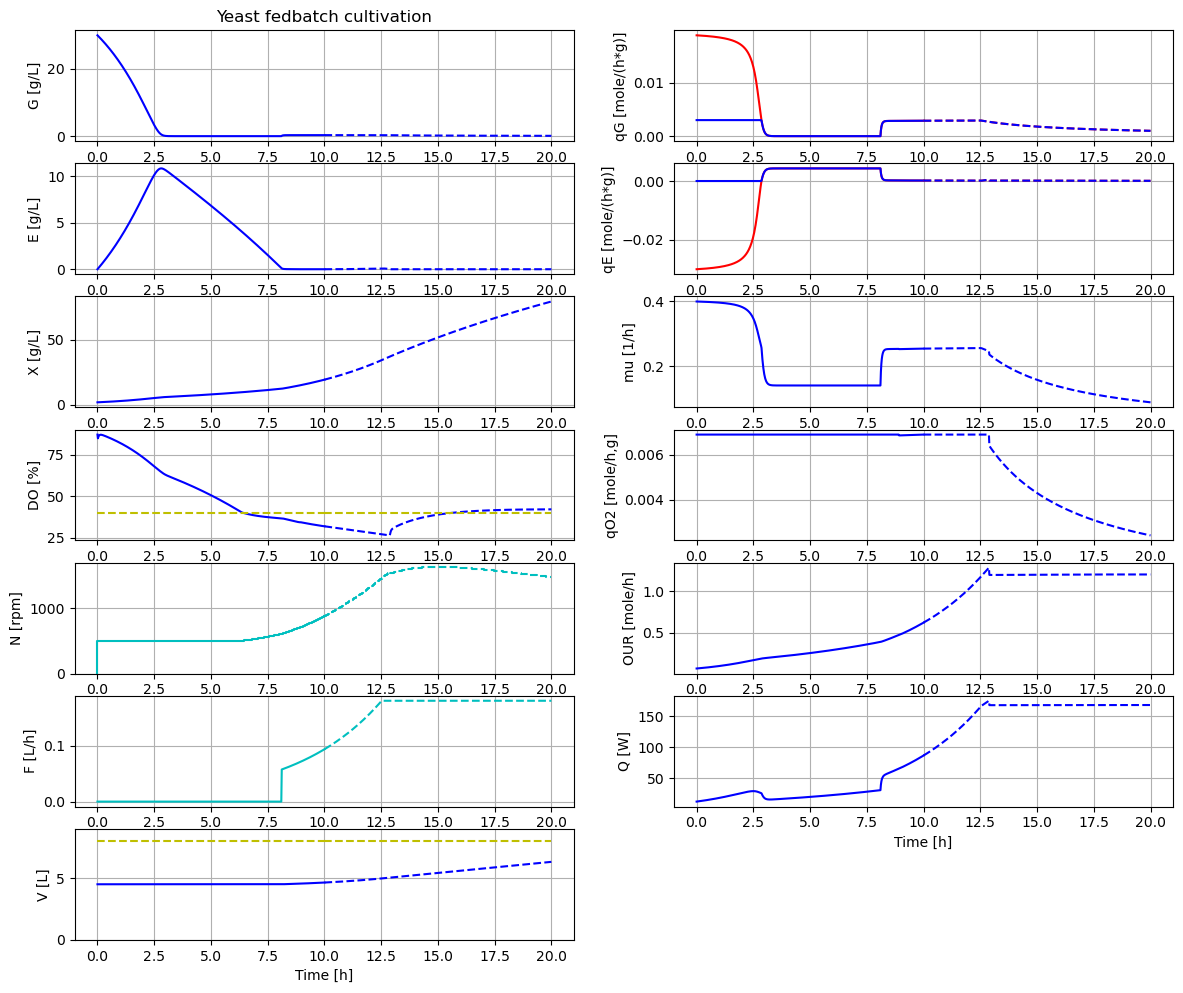

In [15]:
# Check of simu('cont')
newplot(title='Yeast fedbatch cultivation', plotType='Overview')
par(F_startExp=0.057, mu_feed=0.26); simu(10)
simu(10,'cont')

## Make your own diagrams 

There are a couple of pre-defined plotType for the application that you make by the command newplot(). The command result in a list "diagrams" that desccrige the commands that make the plot when you call simu() or you just want to look at the last simulation again with a changed plotType using show().

You can also in Jupyter notebook directly define the list "diagrams" and then that will be used for subsequent calls of simu() or show(). When you have made a diagram that you want to reuse many times you can bring it into the python-setup file and edit the newplot() commmand and add a new plotType. 

Below a few simple examples that show how to do a diagram directly i the notebook

In [16]:
# First decrease the diagram size
plt.rcParams['figure.figsize'] = [24/2.54, 20/2.54]

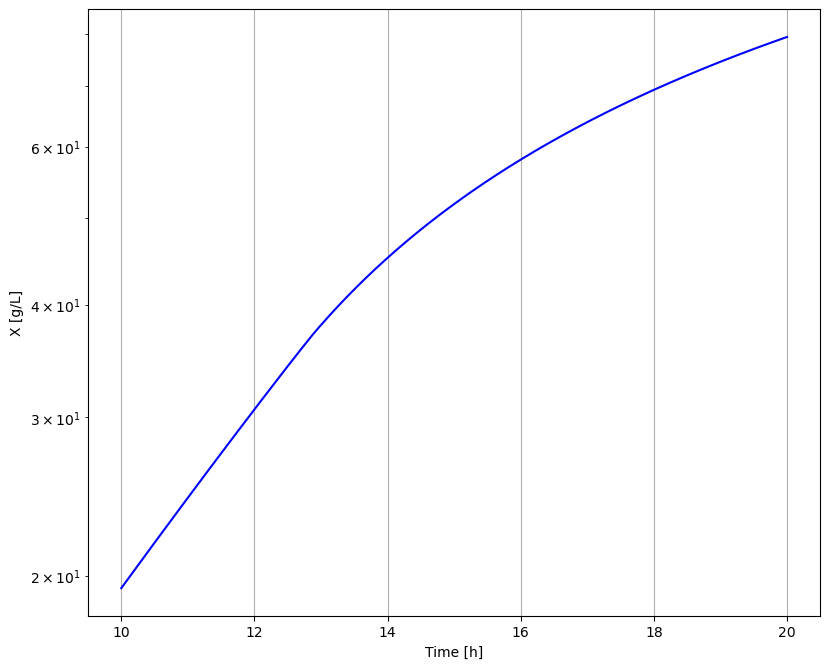

In [17]:
# Improvise and make your own diagram - cell concentration in a logaritmic plot
plt.figure()
ax1 = plt.subplot(1,1,1)
ax1.set_ylabel('X [g/L]')
ax1.set_xlabel('Time [h]')
ax1.grid()

setLines()
diagrams.clear()
diagrams.append("ax1.semilogy(sim_res['time'], sim_res['bioreactor.c[1]'], color='b', linestyle=linetype)")
show()

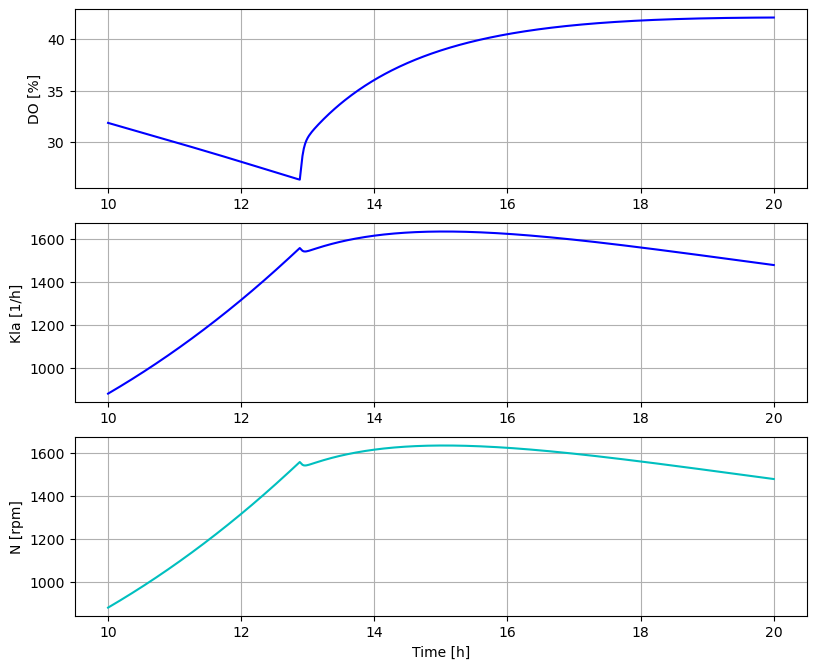

In [18]:
# - study the variation of Kla together with DO and N during cultivation
plt.figure()
ax1 = plt.subplot(3,1,1); ax2 = plt.subplot(3,1,2); ax3 = plt.subplot(3,1,3)
ax1.set_ylabel('DO [%]'); ax1.grid()
ax2.set_ylabel('Kla [1/h]'); ax2.grid()
ax3.set_ylabel('N [rpm]'); ax3.grid()
ax3.set_xlabel('Time [h]')

setLines()
diagrams.clear()
diagrams.append("ax1.plot(sim_res['time'], sim_res['DOsensor.out'], color='b', linestyle=linetype)")
diagrams.append("ax2.plot(sim_res['time'], sim_res['bioreactor.gas_liquid_transfer.Kla_O2'], color='b', linestyle=linetype)")
diagrams.append("ax3.plot(sim_res['time'], sim_res['bioreactor.N'], color='c', linestyle=linetype)")
show()

The relation is Kla = alpha_O2*N and we see the value of the parameter should be around 1.0, and we check below

In [19]:
disp('bioreactor.gas_liquid_transfer.alpha_O2')

alpha_O2 : 1.0


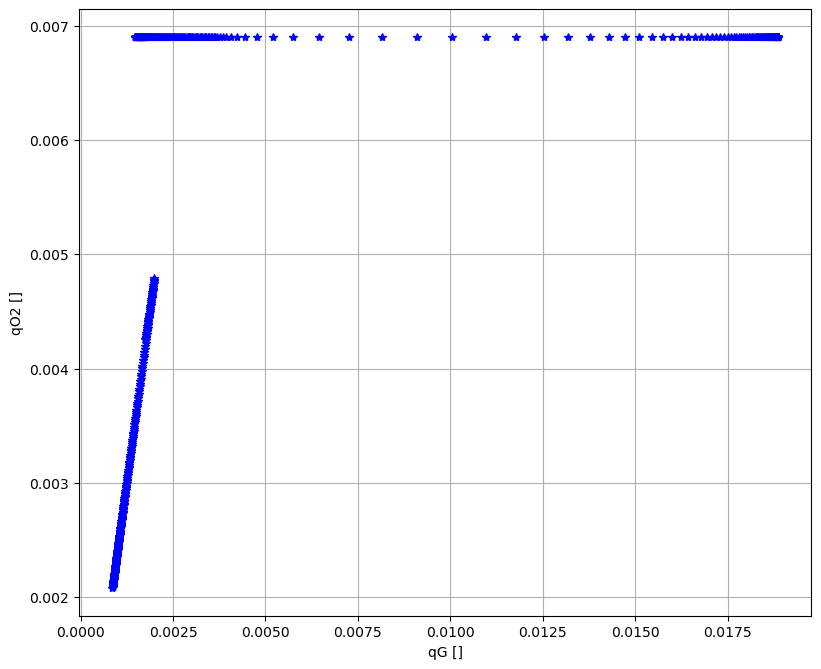

In [20]:
# - study the relation qO2 vs qG(G) 
plt.figure()
ax1 = plt.subplot(1,1,1)
ax1.set_ylabel('qO2 []')
ax1.set_xlabel('qG []')
ax1.grid()

setLines()
diagrams.clear()
diagrams.append("ax1.plot(sim_res['bioreactor.culture.qGm'], sim_res['bioreactor.culture.qO2'], 'b*')")
par(F_start=0.057, mu_feed=0.26)
simu(20)

During the cultivation we have a number of data points for qG and qO2 at the same time, during different conditions. What we see in the diagram is that qO2 increase with qG until qG reach a level of just above 0.0025 and then qO2 saturats for highter qG. This what expect to see.

We also see that for lower qG we have also qO2 values at saturation level. This points correspond to a situation where ethanol is consumed with the remaining respiratory capacity. Glucose is consumed by priority.

## Summary
* We have first seen an overview diagram of a typical yeast fedbatch cultivation where the feed started about an hour after the batch phase was finished. A new simulation was made where the feed started directly after detection of lack of substrate.
* We also took a look at the DO-control system and saw that we could decrease the control error by increasing the PI-controller gain. Stability of the control system remained.
* Then we tested variations in the feed dosage scheme and investigated the possibilities to increae the production.
* We also saw what happens if the feed dosage exceed the culture respiratory capacity and what to look for during the experimental work.
* Finally we saw some examples of how to improvise new diagrams.

## References

[1] Sonnleitner, B. and O. Käppeli "Growth of *Sacharomyces cerevisiae* is controlled by its limited respiratory capacity: formulationa and verification of a hypothesis", Biotech. Bioeng., 1986.

[2] von Stockar, U., Gustafsson, L., Larsson, C., Marison, I., Tissot, P. and Gnaiger E. "Thermodynamic considerations in constructing energy balances for cellular growth", Biochimica et Biophysics Acta, vol 1183, p 221-240, 1993. 

[3] Axelsson, J. P. "Experimental techniques and data analysis to dtermine baker's yeast ethanol dynamics", Anal. Chim. Acta, vol 213, p 151-163, 1988.

## Appendix

In [21]:
disp('culture')

qGmax : 0.02
Ks : 0.001
qO2lim : 0.007


In [22]:
describe('mu')

Cell specific growth rate variable : 0.076 [ 1/h ]


In [23]:
# List of components in the process setup and also a couple of other things like liquidphase and gasphase etc
describe('parts')

['airFlow_setpoint', 'atmosphere', 'bioreactor', 'bioreactor.culture', 'bioreactor.gas_liquid_transfer', 'DO_setpoint', 'dosagescheme', 'DOsensor', 'feedtank', 'gasphase', 'gastube', 'liquidphase', 'MSL', 'N_high', 'N_low', 'PIreg']


In [24]:
describe('MSL')

MSL: RealInput, RealOutput, LimPID-components


In [25]:
system_info()


System information
 -OS: Windows
 -Python: 3.12.3
 -Scipy: not installed in the notebook
 -FMPy: 0.3.20
 -FMU by: JModelica.org
 -FMI: 2.0
 -Type: CS
 -Name: BPL_YEAST_AIR.Fedbatch_DOcontrol
 -Generated: 2024-11-06T13:55:26
 -MSL: 3.2.2 build 3
 -Description: Bioprocess Library version 2.3.0
 -Interaction: FMU-explore for FMPy version 1.0.1
